In [1]:
import torch
import numpy as np
import rasterio
import dl_toolbox.inference as dl_inf

/work/OT/ai4usr/fournip/vre_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dl_toolbox.lightning_modules import *

CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/digi_toulouse_num_train/version_0/checkpoints/epoch=499-step=31499.ckpt'
IN_CHANNELS = 3
NUM_CLASSES = 2
ENCODER = 'efficientnet-b0'
#TRAIN_WITH_VOID = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CKPT_PATH, map_location=device)

module = Unet_BCE(
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    pretrained=False,
    encoder=ENCODER,
    ignore_index=-10
)

# module = DummyModule(model=instantiate(config.model), config_loss=config.loss)
module.load_state_dict(ckpt['state_dict'])
module.eval()
module.to(device);

In [3]:
from dl_toolbox.torch_datasets import *
from dl_toolbox.lightning_datamodules import read_splitfile

#SPLITFILE_PATH = '/d/pfournie/ai4geo/splits/split_scenario_1b.csv'
#DATA_PATH = '/d/pfournie/ai4geo/data/DIGITANIE'
SPLITFILE_PATH = '/home/eh/fournip/expes/splits/split_toulouse.csv'
DATA_PATH = '/work/OT/ai4usr/fournip/digitanie'
CROP_SIZE = 256
CROP_STEP = 256

with open(SPLITFILE_PATH, newline='') as splitfile:
    train_args, val_args = read_splitfile(
        splitfile=splitfile,
        data_path=DATA_PATH,
        train_folds=list(range(3,9)),
        test_folds=[0,1]
    )
    
val_sets = [
        cls(
            labels='binary_labels',
            label_merger='binary_merger',
            img_aug='no',
            crop_size=CROP_SIZE,
            crop_step=CROP_STEP,
            one_hot=False,
            **kwarg
        ) for cls, kwarg in val_args
    ]

In [5]:
from sklearn.metrics import confusion_matrix as confusion_matrix

#MERGE_SEMCITY_TO_COMMON = [[0,7], [3], [6], [2], [4], [1, 5]]
#NUM_CLASSES_COMMON = 6
#merger2 = MergeLabels(MERGE_SEMCITY_TO_COMMON)
BATCH_SIZE = 4
NUM_WORKERS = 4
TTA = ''
MODE = 'sigmoid' # if bce
# MODE = 'softmax' # if ce

global_cm = np.zeros(shape=(NUM_CLASSES, NUM_CLASSES))

for dataset in val_sets:
    
    probas = dl_inf.compute_probas(
        dataset=dataset,
        module=module,
        batch_size=BATCH_SIZE,
        workers=NUM_WORKERS,
        tta=TTA,
        mode=MODE,
        merge=True
    )
    preds = probas.squeeze() > 0.5
    preds = preds[1]

    labels = dataset.read_label(label_path=dataset.label_path, window=dataset.tile).astype(np.uint8)
    row_cm = confusion_matrix(
        labels.flatten(),
        np.squeeze(preds).flatten(),
        labels = np.arange(NUM_CLASSES)
    )

    global_cm += row_cm

batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10
batch  11
batch  12
batch  13
batch  14
batch  15
batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10
batch  11
batch  12
batch  13
batch  14
batch  15


[[6968955.  193892.]
 [ 117610.  719543.]]


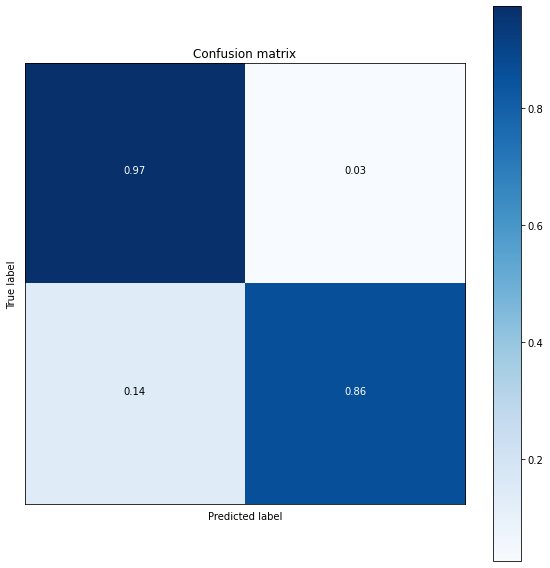

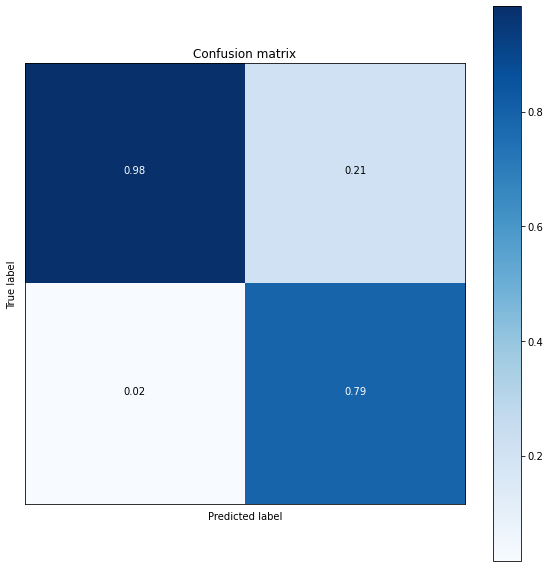

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.callbacks import plot_confusion_matrix
class_names = DigitanieToulouseDs.labels.keys()
print(global_cm)

confmat_recall = global_cm/np.sum(global_cm,axis=1,keepdims=True) 
figure = plot_confusion_matrix(confmat_recall, class_names=class_names)
plt.show()

confmat_prec = global_cm/np.sum(global_cm,axis=0,keepdims=True) 
figure = plot_confusion_matrix(confmat_prec, class_names=class_names)
plt.show()

In [8]:
print('Computing metrics')
metrics_per_class_df, macro_average_metrics_df, micro_average_metrics_df = dl_inf.cm2metrics(global_cm, ignore_index=-1)
metrics_per_class_df.rename(
    index=dict([(i, l) for i, l in enumerate(DigitanieToulouseDs.labels.keys())]),
    inplace=True
)

print(metrics_per_class_df)
print(macro_average_metrics_df)
print(micro_average_metrics_df)

Computing metrics
         F1    Recall  Precision       IoU
0  0.978139  0.972931   0.983404  0.957214
1  0.822059  0.859512   0.787733  0.697877
    macroF1  macroRecall  macroPrecision  macroIoU  OAccuracy     Kappa
0  0.900099     0.916221        0.885568  0.827546   0.961062  0.800245
    microF1  microRecall  microPrecision  microIoU
0  0.961062     0.961062        0.961062  0.925043


In [ ]:
with pd.ExcelWriter(os.path.join(args.output_path, 'metrics.xlsx')) as writer:
    metrics_per_class_df.to_excel(writer, sheet_name='metrics_per_class')
    average_metrics_df.to_excel(writer, sheet_name='average_metrics')